# Classifier Evaluation Lab

* Copy&paste your model for homework5 model
* Add grid search and train
* Compare performance
* Which one is better? Explain?

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

df = pd.read_csv('https://raw.githubusercontent.com/msaricaumbc/DS_data/master/ds602/log_reg/employee-turnover-balanced.csv')
df.head()

,left_company,age,frequency_of_travel,department,commuting_distance,education,satisfaction_with_environment,gender,seniority_level,position,satisfaction_with_job,married_or_single,last_raise_pct,last_performance_rating,total_years_working,years_at_company,years_in_current_job,years_since_last_promotion,years_with_current_supervisor
0,No,37,Travel_Rarely,Sales,16,4,4,Male,2,Sales Executive,3,Divorced,19,3,9,1,0,0,0
1,No,39,Travel_Rarely,Research & Development,3,2,3,Male,2,Laboratory Technician,3,Divorced,15,3,11,10,8,0,7
2,No,52,Travel_Frequently,Research & Development,25,4,3,Female,4,Manufacturing Director,4,Married,22,4,31,9,8,0,0
3,No,50,Non-Travel,Sales,1,3,4,Female,2,Sales Executive,3,Married,12,3,19,18,7,0,13
4,No,44,Travel_Rarely,Research & Development,4,3,4,Male,2,Healthcare Representative,2,Single,12,3,10,5,2,2,3


In [11]:
cat = ['frequency_of_travel','department','education','satisfaction_with_environment','gender','seniority_level', 'satisfaction_with_job','last_performance_rating','position','married_or_single']
categorical = df[cat].astype('object')


drop_df = df.drop(columns= cat)
drop_df = drop_df.drop(['left_company'],axis =1)

In [12]:
cat_list = categorical.columns.tolist()
cat_list

['frequency_of_travel',
 'department',
 'education',
 'satisfaction_with_environment',
 'gender',
 'seniority_level',
 'satisfaction_with_job',
 'last_performance_rating',
 'position',
 'married_or_single']

In [13]:
num = drop_df.columns.tolist()
num

['age',
 'commuting_distance',
 'last_raise_pct',
 'total_years_working',
 'years_at_company',
 'years_in_current_job',
 'years_since_last_promotion',
 'years_with_current_supervisor']

<AxesSubplot:>

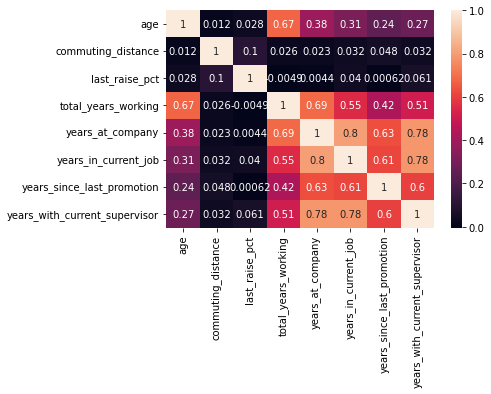

In [19]:
sns.heatmap(drop_df.corr(), annot=True)

In [21]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
variance = pd.DataFrame()
variance["feature"] = drop_df.columns
variance["VIF"] = [variance_inflation_factor(drop_df.values, i) for i in range(len(drop_df.columns))]
variance.sort_values(by = 'VIF',ascending = False)

,feature,VIF
0,age,16.669850
2,last_raise_pct,10.656507
4,years_at_company,9.588173
5,years_in_current_job,7.656341
3,total_years_working,7.622769
7,years_with_current_supervisor,6.888652
6,years_since_last_promotion,2.590716
1,commuting_distance,2.389730


In [24]:
X = pd.concat([categorical,drop_df],axis=1)

In [25]:
from sklearn.model_selection import train_test_split

Y = df['left_company']
X_train,X_test,y_train,y_test = train_test_split(X, Y, test_size =  0.2, random_state = 124)

In [27]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.impute import SimpleImputer

cat_pipeline = Pipeline(steps = [('imputer', SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')),('onehotencoder',  OneHotEncoder(handle_unknown = 'ignore',drop = 'first'))])
X_train_cat_converted = cat_pipeline.fit_transform(X_train[cat_list])
X_train_cat_converted.todense()

matrix([[0., 1., 1., ..., 0., 0., 1.],
        [0., 1., 1., ..., 0., 1., 0.],
        [0., 0., 1., ..., 0., 1., 0.],
        ...,
        [0., 1., 1., ..., 0., 1., 0.],
        [0., 0., 1., ..., 0., 1., 0.],
        [0., 1., 1., ..., 0., 0., 1.]])

In [34]:
num_pipeline = Pipeline(steps = [('imputer', SimpleImputer(missing_values = np.nan, strategy = 'median')),('scaler',  StandardScaler())])

X_train_numeric_converted = num_pipeline.fit_transform(X_train[num])

In [38]:
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
preprocessor = ColumnTransformer(transformers = [('num', num_pipeline,num),('cat',cat_pipeline, cat_list)])

In [40]:
pipeline = Pipeline(steps = [('preprocessor', preprocessor), ('regressor', LogisticRegression(C=1000,max_iter=10000))])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

s = pipeline.score(X_test,y_test)

In [41]:
grid = [
  {'logreg__class_weight': [None, 'balanced'], 'logreg__C':[0.01, 0.1, 1, 10, 100]}
 ]

param = {
    'regressor__penalty' : ['l2'], 
    'regressor__C'       : np.logspace(-3,3,7),
    'regressor__solver'  : ['newton-cg', 'lbfgs', 'liblinear'],
}

In [43]:
from sklearn.model_selection import GridSearchCV
grid_cv = GridSearchCV(estimator= pipeline, param_grid=param, scoring='accuracy', cv=10)
grid_cv = grid_cv.fit(X_train, y_train)

In [44]:
y_pred_gcv = grid_cv.predict(X_test)
y_score = grid_cv.score(X_test,y_test)
print(y_score)

0.725


In [47]:
train_score= grid_cv.score(X_train,y_train)
print(train_score)
print(grid_cv.best_score_)

0.73625
0.715


In [50]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_gcv))

              precision    recall  f1-score   support

          No       0.71      0.70      0.70        93
         Yes       0.74      0.75      0.74       107

    accuracy                           0.73       200
   macro avg       0.72      0.72      0.72       200
weighted avg       0.72      0.72      0.72       200



# Explanation

Comparing Grid Search cv to the previously trained model, the overall accuracy improved.

Recall for identifying the baseline increased from 0.72 to 0.75.

Precision for identifying the affirmative class increased from 0.71 to 0.73.

Consequently, when compared to the prior model, the hypertuned model given by the grid search cv performed at its peak.
Due to the training score being 0.7325 and the assessment score being 0.72, there was also a reduction in overfitting.